# ARIMA Forecasting - AAPL
This notebook loads historical stock price data for Apple (AAPL), fits an ARIMA model, and forecasts future closing prices.

In [2]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


sns.set(style="whitegrid")

In [3]:
# Load historical data
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2023-12-31")
data = data[["Close"]].dropna()
data.columns = [ticker]
data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,AAPL
Date,
2015-01-02,24.288576
2015-01-05,23.604332
2015-01-06,23.606554
2015-01-07,23.937576
2015-01-08,24.857306


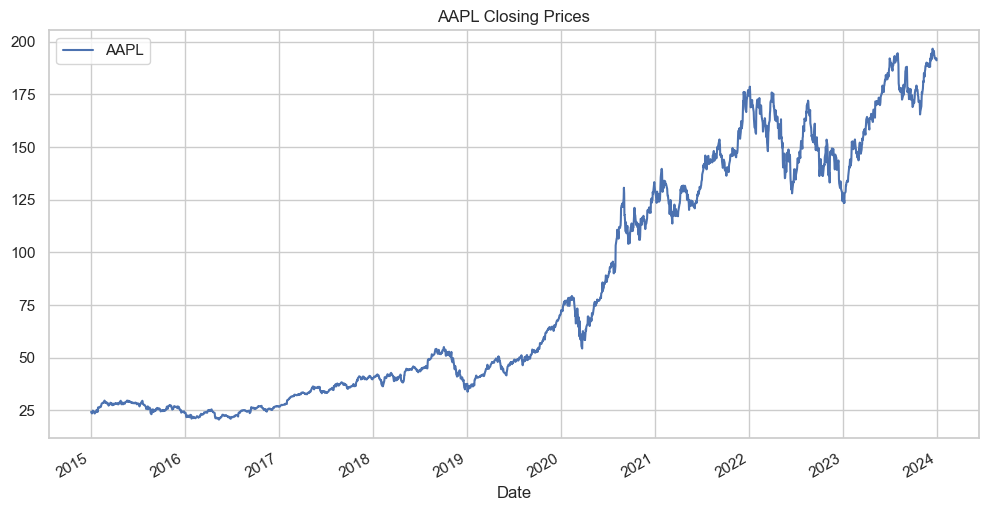

In [4]:
# Plot closing prices
data.plot(title=f"{ticker} Closing Prices", figsize=(12, 6))
plt.show()

In [5]:
# ADF test for stationarity
result = adfuller(data[ticker])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.24379353962536693
p-value: 0.9746136074443112


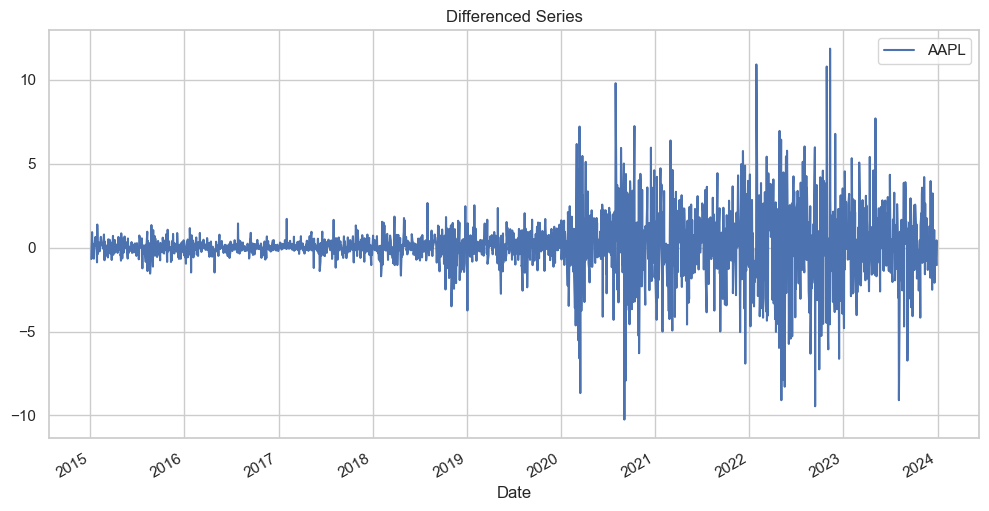

In [6]:
# Differencing if necessary
data_diff = data.diff().dropna()
data_diff.plot(title="Differenced Series", figsize=(12, 6))
plt.show()

In [ ]:
# Split into train and test
train = data[:-365]
test = data[-365:]

# Split
train = data[:'2022']
test = data['2023':]

# Debug checks
print("Train shape:", train.shape)
print("Train NaNs:", train.isna().sum().sum())
print("Test shape:", test.shape)
print("Test NaNs:", test.isna().sum().sum())
print("Test tail:\n", test.tail(10))


# Before using `test`, drop rows with NaNs in your target column
test = test.dropna()

# Then recompute the forecast to match new test length
forecast = auto_model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)


Train shape: (2014, 1)
Train NaNs: 0
Test shape: (250, 1)
Test NaNs: 0
Test tail:
                   AAPL
Date                  
2023-12-15  196.133698
2023-12-18  194.465897
2023-12-19  195.508270
2023-12-20  193.413620
2023-12-21  193.264694
2023-12-22  192.192551
2023-12-26  191.646561
2023-12-27  191.745804
2023-12-28  192.172729
2023-12-29  191.130325


NameError: name 'auto_model' is not defined

In [ ]:
from pmdarima import auto_arima

# Automatically select best ARIMA model
auto_model = auto_arima(
    train, 
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True, 
    stepwise=True
)

print(f"Selected ARIMA order: {auto_model.order}")

# Forecast the test period
forecast = auto_model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)

raw_forecast = auto_model.predict(n_periods=len(test))
forecast = pd.Series(raw_forecast, index=test.index)

print("Raw forecast:\n", raw_forecast[:10])
print("NaNs in raw forecast:", np.isnan(raw_forecast).sum())



In [ ]:
# Plot forecast vs actual
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(forecast, label="Forecast")
plt.title(f"ARIMA Forecast for {ticker}")
plt.legend()
plt.show()

In [ ]:
# 1. Drop NaNs from training data
train = train.dropna()

# 2. Fit ARIMA model
auto_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print("Fitted model order:", auto_model.order)

# 3. Forecast
forecast = auto_model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)

# 4. Clean up for evaluation
true = test[ticker].values
pred = forecast.values

# Debug: check for NaNs/Infs
print("NaNs in forecast:", np.isnan(pred).sum())

# 5. Drop any remaining invalid values before evaluation
mask = ~np.isnan(true) & ~np.isnan(pred) & ~np.isinf(true) & ~np.isinf(pred)
true_clean = true[mask]
pred_clean = pred[mask]




print("Length of cleaned true:", len(true_clean))
print("Length of cleaned pred:", len(pred_clean))
print("true_clean[:5]:", true_clean[:5])
print("pred_clean[:5]:", pred_clean[:5])


# 6. Evaluate only if we have valid values
if len(true_clean) > 0 and len(pred_clean) > 0:
    mse = mean_squared_error(true_clean, pred_clean)
    mae = mean_absolute_error(true_clean, pred_clean)

    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
else:
    print("⚠️ Not enough valid forecast data to evaluate. Check for NaNs or bad inputs.")

print("Train shape:", train.shape)
print("Train index dtype:", train.index.dtype)
print("Train head:\n", train.head())

print("Test shape:", test.shape)
print("Test head:\n", test.head())

print("Forecast head:\n", forecast.head())
print("NaNs in forecast:", np.isnan(forecast.values).sum())




In [ ]:
# Save forecast vs. actual to CSV
results_df = pd.DataFrame({
    "Actual": test[ticker],
    "Forecast": forecast
})
results_df.to_csv("../output/predictions.csv")
print("Forecast saved to output/predictions.csv")

In [ ]:
# Plot forecast vs actual and save
plt.figure(figsize=(12, 6))
plt.plot(train, label="Train", color="blue")
plt.plot(test, label="Test", color="orange")
plt.plot(forecast, label="Forecast", color="green", linestyle="--")  # Add color & style

plt.title(f"ARIMA Forecast for {ticker}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("output/arima_forecast.png")  # Use consistent path
print("Plot saved to output/arima_forecast.png")
plt.show()
